In [14]:
import pyspark as ps
from pyspark.sql.functions import col, when, min, max, avg, stddev, count
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Create a spark context
sc = ps.SparkContext()
# Create a spark session
spark = ps.sql.SparkSession(sc)

24/07/27 18:03:10 WARN Utils: Your hostname, MacBook-Air-de-Abdurrahim.local resolves to a loopback address: 127.0.0.1; using 192.168.1.128 instead (on interface en0)
24/07/27 18:03:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/27 18:03:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Load the data
data = spark.read.csv('dataseter.csv', header=True, inferSchema=True)

In [5]:
data.show()
#print number of rows
n = data.count()

+------+---+-------+--------------+-------+-------------+---------------+-------+-------+--------+-----------------+--------+-------------------+---------------------+----------+-----------+
|GENDER|AGE|SMOKING|YELLOW_FINGERS|ANXIETY|PEER_PRESSURE|CHRONIC_DISEASE|FATIGUE|ALLERGY|WHEEZING|ALCOHOL_CONSUMING|COUGHING|SHORTNESS_OF_BREATH|SWALLOWING_DIFFICULTY|CHEST_PAIN|LUNG_CANCER|
+------+---+-------+--------------+-------+-------------+---------------+-------+-------+--------+-----------------+--------+-------------------+---------------------+----------+-----------+
|     M| 65|    Yes|           Yes|    Yes|           No|             No|    Yes|     No|      No|               No|      No|                 No|                   No|       Yes|         NO|
|     F| 55|    Yes|            No|     No|          Yes|            Yes|     No|     No|      No|              Yes|     Yes|                Yes|                   No|        No|         NO|
|     F| 78|     No|            No|    Yes|  

In [6]:
transformed_data = data
#Iterate each column and check whether the valeus are of type "Yes", "No", if they are, replace yes with 1 and no with 0
for column in data.columns:
    transformed_data = transformed_data.withColumn(column, when(col(column) == "Yes", 1).when(col(column) == "No", 0).otherwise(col(column)))
transformed_data = transformed_data.withColumn("LUNG_CANCER", when(col("LUNG_CANCER") == "YES", 1).when(col("LUNG_CANCER") == "NO", 0).otherwise(col("LUNG_CANCER")))
    

In [7]:
transformed_data.show()

+------+---+-------+--------------+-------+-------------+---------------+-------+-------+--------+-----------------+--------+-------------------+---------------------+----------+-----------+
|GENDER|AGE|SMOKING|YELLOW_FINGERS|ANXIETY|PEER_PRESSURE|CHRONIC_DISEASE|FATIGUE|ALLERGY|WHEEZING|ALCOHOL_CONSUMING|COUGHING|SHORTNESS_OF_BREATH|SWALLOWING_DIFFICULTY|CHEST_PAIN|LUNG_CANCER|
+------+---+-------+--------------+-------+-------------+---------------+-------+-------+--------+-----------------+--------+-------------------+---------------------+----------+-----------+
|     M| 65|      1|             1|      1|            0|              0|      1|      0|       0|                0|       0|                  0|                    0|         1|          0|
|     F| 55|      1|             0|      0|            1|              1|      0|      0|       0|                1|       1|                  1|                    0|         0|          0|
|     F| 78|      0|             0|      1|  

F 1486 ( 49.53333333333333 %)
M 1514 ( 50.46666666666667 %)
30 80
55.169
0 1473 ( 49.1 %)
1 1527 ( 50.9 %)


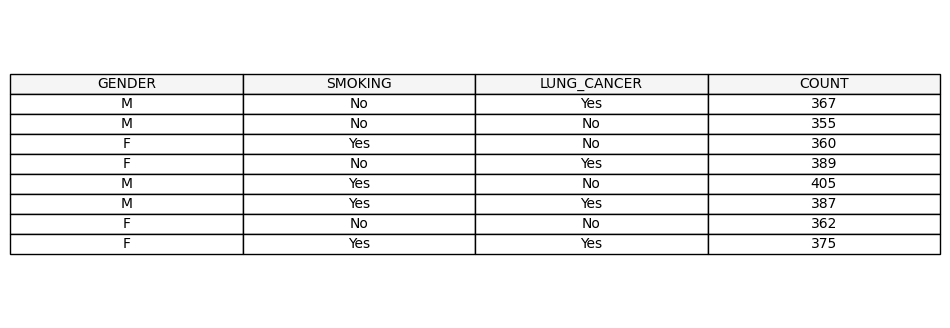

In [8]:
#descriptive analysis of the data
genderCount = transformed_data.select("GENDER").groupBy("GENDER").count()
collectedGenderCount = genderCount.collect()
for row in collectedGenderCount:
    print(row["GENDER"], row["count"], "(", row["count"]/n*100, "%)")

#range of age
minAge = transformed_data.select(min("AGE")).collect()[0][0]
maxAge = transformed_data.select(max("AGE")).collect()[0][0]
print(minAge, maxAge)
#mean age
meanAge = transformed_data.select(avg("AGE")).collect()[0][0]
print(meanAge)

#smoking status
smokingCount = transformed_data.select("SMOKING").groupBy("SMOKING").count()
for row in smokingCount.collect():
    print(row["SMOKING"], row["count"], "(", row["count"]/n*100, "%)")

smokeCancerF = data.select("GENDER", "SMOKING", "LUNG_CANCER")\
.groupBy("GENDER","SMOKING", "LUNG_CANCER")\
.count()\
.toPandas()

#smokeCancerF.show()
#rename the count column as Number
smokeCancerF = smokeCancerF.rename(columns={"count":"COUNT"})
#in the lung_cancer column, replace YES with Yes and NO with No
smokeCancerF["LUNG_CANCER"] = smokeCancerF["LUNG_CANCER"].replace({"YES":"Yes", "NO":"No"})


#produce an image of a table with the smokeCanerF data
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 4))  # Set size as needed

# Hide the axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 
ax.set_frame_on(False) 

# Create a table
table = ax.table(cellText=smokeCancerF.values, colLabels=smokeCancerF.columns, cellLoc='center', loc='center', colColours=['#f5f5f5']*len(smokeCancerF.columns))

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust scaling as needed

# Save the table as an image
plt.savefig('table_image.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

/var/folders/37/jg2s9gps3w3d6jvvk9q1fvnr0000gn/T/ipykernel_7551/2191222210.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  smokeAndCancer = smokeAndCancer.replace("F", 0)


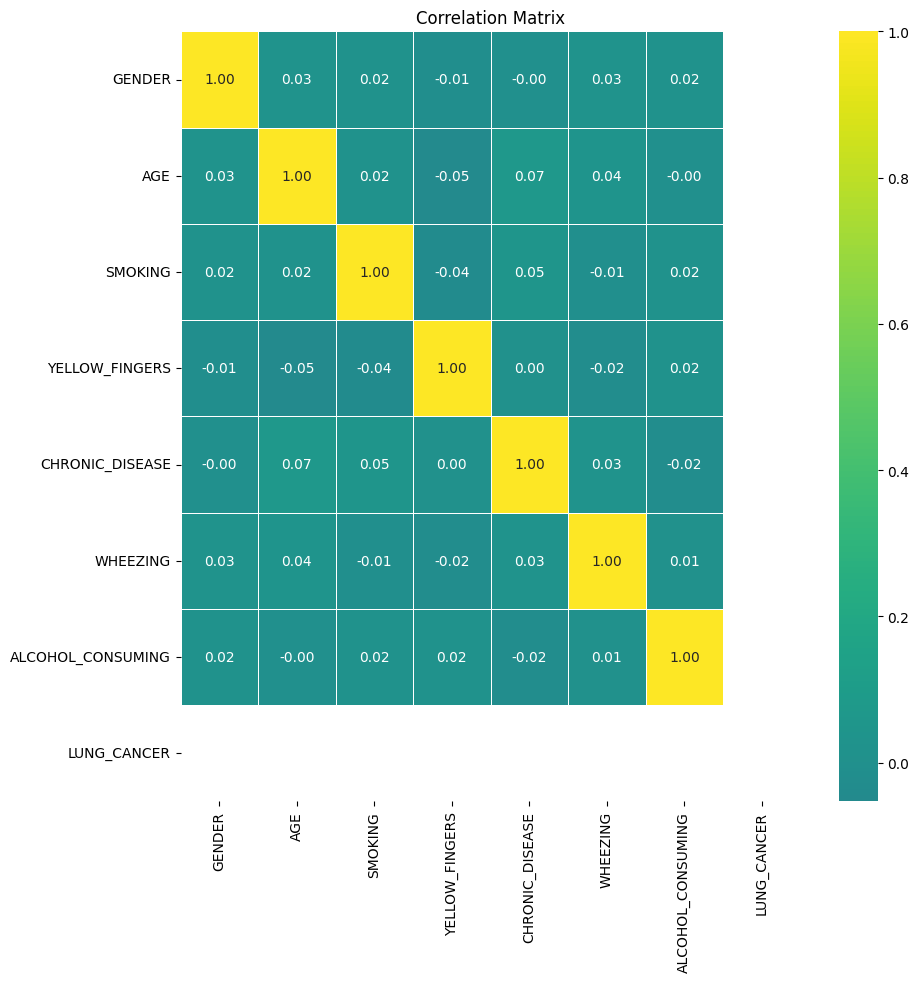

In [9]:
#heatmap of the correlation matrix
smokeAndCancer = transformed_data.select("GENDER", "AGE", "SMOKING", "YELLOW_FINGERS", "CHRONIC_DISEASE", "WHEEZING", "ALCOHOL_CONSUMING", "LUNG_CANCER" )\
.where("LUNG_CANCER == 1")\
.toPandas()
#transform the GENDER column to numerical values
smokeAndCancer = smokeAndCancer.replace("M", 1)
smokeAndCancer = smokeAndCancer.replace("F", 0)

corrMAtrix = smokeAndCancer.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corrMAtrix, annot=True, fmt=".2f", linewidths=0.5, cmap="viridis", center=0)
plt.title("Correlation Matrix")
plt.show()

/Users/abdu/.pyenv/versions/3.11.5/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/abdu/.pyenv/versions/3.11.5/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


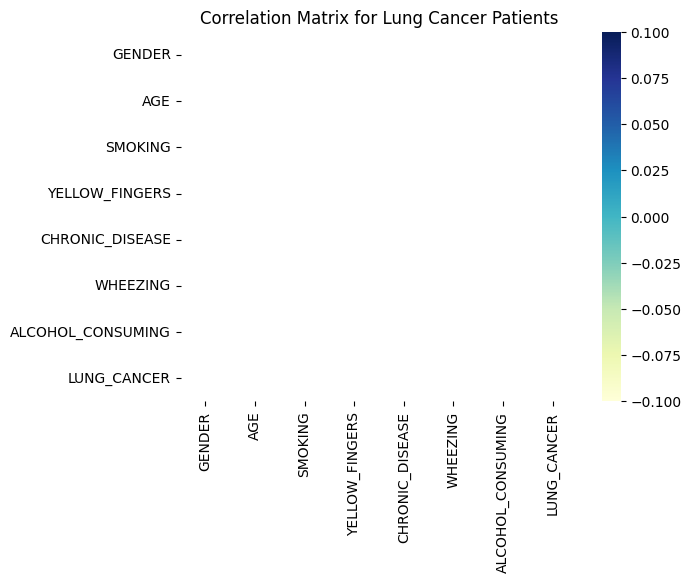

In [10]:
lung_cancer_patients = smokeAndCancer[smokeAndCancer['LUNG_CANCER'] == 1]
sns.heatmap(lung_cancer_patients.corr(), annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix for Lung Cancer Patients')
plt.show()

In [11]:
#Percentage of people in the sample that smoked and had lung cancer
smokeCancer = transformed_data.select("GENDER", "SMOKING", "LUNG_CANCER") \
.where("SMOKING == 1")\
.where("LUNG_CANCER == 1")\
.groupBy("GENDER").count()
smokeCancer.show()

smokeCancerCollected = smokeCancer.collect()


smokeCancerF = 0
smokeCancerM = 0

for row in smokeCancerCollected:
    if row['GENDER'] == 'F':
        smokeCancerF = row['count']
    elif row['GENDER'] == 'M':
        smokeCancerM = row['count']

smokeCancerF = (smokeCancerF/n)*100
smokeCancerM = (smokeCancerM/n)*100

print("Percentage of females in the sample that smoked and had lung cancer", smokeCancerF)
print("Percentage of males in the sample that smoked and had lung cancer", smokeCancerM)




+------+-----+
|GENDER|count|
+------+-----+
|     F|  375|
|     M|  387|
+------+-----+

Percentage of females in the sample that smoked and had lung cancer 12.5
Percentage of males in the sample that smoked and had lung cancer 12.9


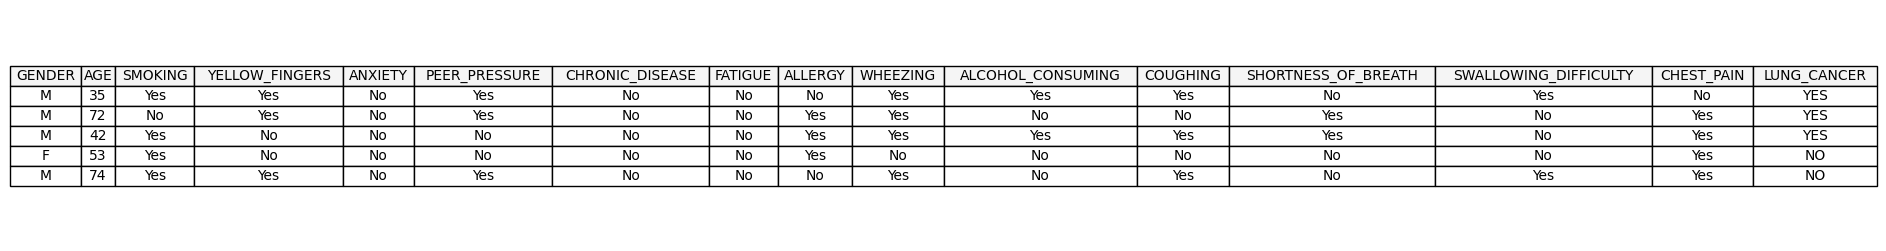

In [12]:
import matplotlib.pyplot as plt

# Sample data
sample = data.toPandas().sample(5)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(4, 3))  # Adjust size as needed

# Hide the axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 
ax.set_frame_on(False) 

# Create a table
table = ax.table(cellText=sample.values, colLabels=sample.columns, cellLoc='center', loc='center', colColours=['#f5f5f5']*len(sample.columns))

# Auto adjust column width
table.auto_set_column_width(col=[i for i in range(len(sample.columns))])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust scaling as needed

# Save the table as an image
plt.savefig('table_image.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


LUNG_CANCER     0     1   All
SMOKING                      
0             717   756  1473
1             765   762  1527
All          1482  1518  3000


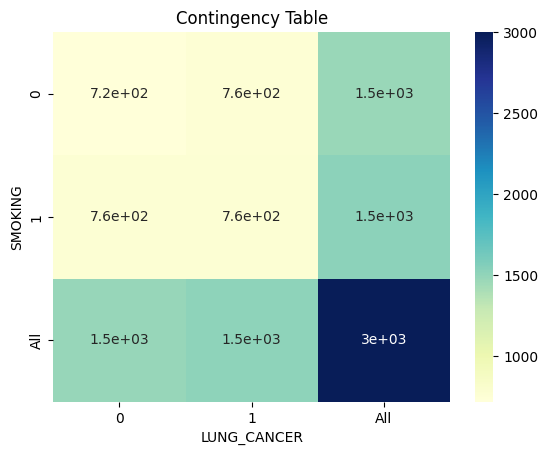

ModuleNotFoundError: No module named 'scipy'

In [16]:
#test1 - Null Hypothesis (H0): There is no association between smoking and lung cancer.

#Alternative Hypothesis: There is an association between smoking and lung cancer.

contingecyData= transformed_data.select("SMOKING", "LUNG_CANCER").toPandas()
contingecyTable = pd.crosstab(contingecyData["SMOKING"], contingecyData["LUNG_CANCER"], margins=True)
print(contingecyTable)

#get an image of the contingency table using seaborn
sns.heatmap(contingecyTable, cmap='YlGnBu')
plt.title('Contingency Table')
plt.show()


#chi-square test
from scipy.stats import chi2_contingency
